In [2]:
import stompy.model.delft.dflow_model as dfm
from stompy.grid import unstructured_grid
import xarray as xr
import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib notebook

In [ ]:
# Debugging the grid issues...
run_dir="data_2d_2019_hybrid-v031"

# This is the grid I *thought* I was targeting.
ds_int = xr.open_dataset(os.path.join(run_dir,"DFM_interpreted_idomain_grid-bathy-base_net.nc"))
# The grid I provided as input
ds_orig= xr.open_dataset(os.path.join(run_dir,"grid-bathy-base_net.nc"))

# The per-processor information via BMI (for a problem domain like 4):
ds_bmi = xr.open_dataset(os.path.join(run_dir,"bmi-grid-0004.nc"))

# Maybe the easiest is to just use the cell center coordinates. Can use the interpreted 
# domain in case cell centers were adjusted.
g_int = unstructured_grid.UnstructuredGrid.read_dfm(ds_int)

In [15]:
cc = np.c_[ ds_bmi.xz.values, ds_bmi.yz.values]
loc_to_global = [ g_int.select_cells_nearest(p,inside=True) for p in cc]

In [19]:
# cell centers from BMI that are not inside an input cell.
missed = [i for i,gidx in enumerate(loc_to_global) if gidx is None]
missed

[93,
 672,
 709,
 3991,
 4933,
 5815,
 6137,
 6382,
 6426,
 7586,
 7596,
 7597,
 7643,
 7856,
 7879,
 8137,
 8138,
 8139,
 8140,
 8141,
 8142,
 8143]

In [25]:
ds_bmi

<xarray.Dataset>
Dimensions:       (nump1d2d: 8137, net_elem_max_nodes: 4, ndx2d: 8137,
                   flow_elem_max_nodes: 4, ndx: 8144, flow_elem_max_nbs: 4,
                   numk: 6045)
Dimensions without coordinates: nump1d2d, net_elem_max_nodes, ndx2d,
                                flow_elem_max_nodes, ndx, flow_elem_max_nbs,
                                numk
Data variables:
    netelemnode   (nump1d2d, net_elem_max_nodes) int32 ...
    flowelemnode  (ndx2d, flow_elem_max_nodes) int32 ...
    flowelemnbs   (ndx, flow_elem_max_nbs) int32 ...
    flowelemlns   (ndx, flow_elem_max_nbs) int32 ...
    iglobal_s     (ndx) int32 ...
    ndxi          int32 ...
    ndx1db        int32 ...
    lnxi          int32 ...
    xk            (numk) float64 ...
    yk            (numk) float64 ...
    xz            (ndx) float64 6.047e+05 6.047e+05 ... 6.047e+05 6.048e+05
    yz            (ndx) float64 4.237e+06 4.237e+06 ... 4.237e+06 4.237e+06

In [29]:
# has 11 duplicate mappings.
# 8135 unique cells, but 8144 entries.
# 8144 is ndx. nump1d2d==ndx2d==8137
#len(np.unique(loc_to_global)), len(loc_to_global) # 8135, 8144
#ds_bmi

iglobal_s0=ds_bmi.iglobal_s.values - 1
iglobal_flow=iglobal_s0[:ds_bmi.dims["ndx2d"]]
iglobal_s0.max() # 125093
iglobal_flow.max() # 106795

106795

<IPython.core.display.Javascript object>


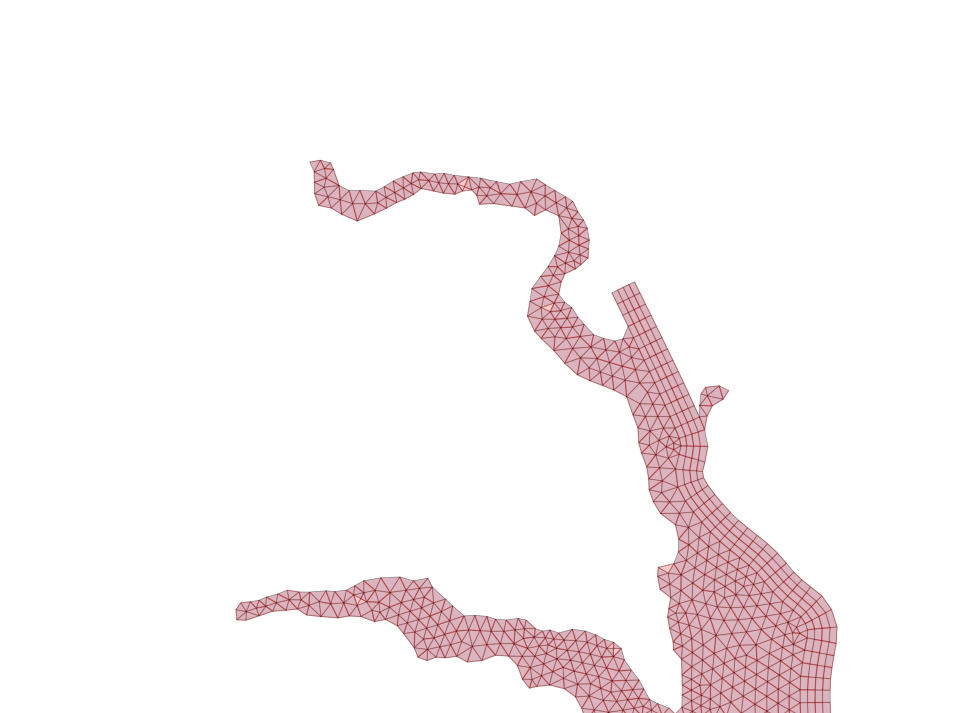

In [30]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ax.axis('off')
ax.set_position([0,0,1,1])

g_int.plot_edges(color='k',lw=0.5,alpha=0.4,ax=ax)

# This is Lindsey Slough, including Barker. 
g_int.plot_cells(mask=[i for i in loc_to_global if i is not None],alpha=0.2)

# The direct way
g_int.plot_cells(mask=iglobal_flow,color='r',alpha=0.2)

# lots of these miss because the cell center is on an edge. For those
# we could just be more permissive in select cells.
# There are some cases where the cell center is on an edge, and appears
# to tall inside a neighboring cell, so that cell is mapped twice, and we
# get a hole. Testing against cell centers might help there.
# And there are 7 points that fall outside the domain as BCs.

#missing_cc=cc[missed]
#ax.plot(missing_cc[:,0],missing_cc[:,1],'ro')

In [32]:
ds_bmi.ndxi.values

array(8137, dtype=int32)

In [2]:
# data_2d_2019_hybrid: Appears not to have the dwaq tracers. Bug in hybrid_model. Fixed.

model=dfm.DFlowModel.load("data_2d_2019_hybrid-v008")

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:1133: RuntimeWarning: invalid value encountered in cast
  cells=cells.astype(np.int32)


In [10]:
map_ds=model.map_dataset()

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:872: RuntimeWarning: invalid value encountered in cast
  ug.edges['cells'] = nc[mesh.attrs['edge_face_connectivity']].values
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned n

In [4]:
from stompy.plot import nbviz

<IPython.core.display.Javascript object>


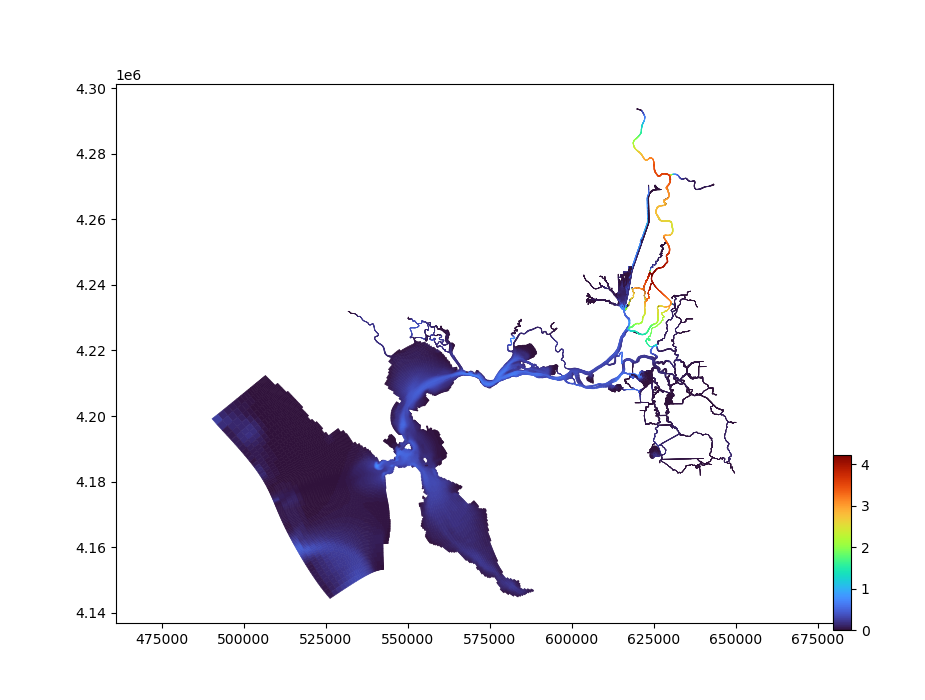

Checking for edge vars
edge dimension: mesh2d_nEdges


NBViz(children=(VBox(children=(Label(value='Coordinates'),), layout=Layout(grid_area='header')), Select(descri…

Will update/create coordinate pane


In [5]:
nbviz.NBViz(datasets=[map_ds])

In [8]:
map_ds.dims

Frozen({'mesh2d_nNodes': 10362, 'mesh2d_nEdges': 19189, 'Two': 2, 'mesh2d_nFaces': 8828, 'mesh2d_nMax_face_nodes': 4, 'time': 721})

<IPython.core.display.Javascript object>


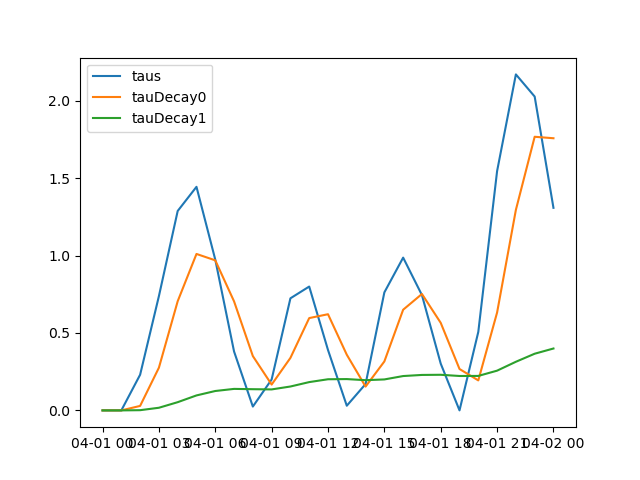

In [12]:
# Check tau time series vs tauDecay timeseries
# select some reasonable point with decent bed stress.
#xy=[624290, 4241584]
xy=[550450,4204570]
c=map_ds.grid.select_cells_nearest(xy)

fig,ax=plt.subplots()
taus=map_ds['mesh2d_taus'].isel(mesh2d_nFaces=c)
tauDecay0=map_ds['mesh2d_tauDecay0'].isel(mesh2d_nFaces=c)
tauDecay1=map_ds['mesh2d_tauDecay1'].isel(mesh2d_nFaces=c)

ax.plot(taus.time, taus,label='taus')
ax.plot(tauDecay0.time, tauDecay0,label='tauDecay0')
ax.plot(tauDecay1.time, tauDecay1,label='tauDecay1')

ax.legend()

In [3]:
# See if numbering of the map outputs matches the partitioned net files
# no, there is some renumbering in between...
proc=4
map_fn_proc = model.map_outputs()[proc]
map_ds_proc = xr.open_dataset(map_fn_proc)
map_g_proc = unstructured_grid.UnstructuredGrid.read_ugrid(map_ds_proc)

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:872: RuntimeWarning: invalid value encountered in cast
  ug.edges['cells'] = nc[mesh.attrs['edge_face_connectivity']].values


In [4]:
part_g_proc = model.subdomain_grid(proc)

/home/rustyh/src/stompy/stompy/grid/unstructured_grid.py:1133: RuntimeWarning: invalid value encountered in cast
  cells=cells.astype(np.int32)


In [5]:
part_g_proc.cells.dtype

dtype([('edges', '<i4', (4,)), ('nodes', '<i4', (4,)), ('_center', '<f8', (2,)), ('mark', '<i4'), ('_area', '<f8'), ('deleted', '?'), ('iglobal_s', '<i4')])

In [7]:
g_global=model.grid

'data_2d_2019_hybrid-v008/grid-bathy-base_net.nc'

In [21]:

g_global = unstructured_grid.UnstructuredGrid.read_dfm(
    os.path.join( model.run_dir, 
                 'DFM_interpreted_idomain_' + model.mdu['geometry','NetFile']))

<IPython.core.display.Javascript object>


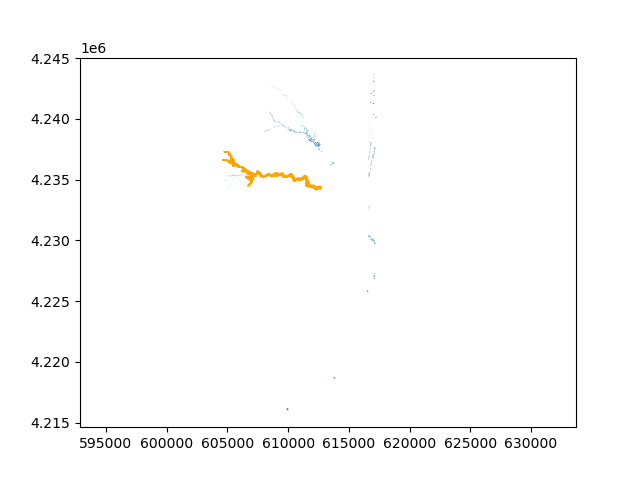

(603675.532665, 622885.007235, 4214616.90783156, 4245055.726988973)

In [24]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')

# This one works.
g_global.plot_cells(mask=part_g_proc.cells['iglobal_s']-1)
part_g_proc.plot_edges(color='orange',lw=0.8)
ax.axis('equal')

In [24]:
list(map_ds_proc)

['projected_coordinate_system',
 'mesh2d',
 'mesh2d_node_z',
 'mesh2d_edge_nodes',
 'mesh2d_face_nodes',
 'mesh2d_edge_faces',
 'mesh2d_face_x_bnd',
 'mesh2d_face_y_bnd',
 'mesh2d_edge_type',
 'mesh2d_flowelem_ba',
 'mesh2d_flowelem_bl',
 'mesh2d_flowelem_domain',
 'mesh2d_flowelem_globalnr',
 'timestep',
 'mesh2d_Numlimdt',
 'mesh2d_s1',
 'mesh2d_s0',
 'mesh2d_waterdepth',
 'mesh2d_u1',
 'mesh2d_u0',
 'mesh2d_ucx',
 'mesh2d_ucy',
 'mesh2d_ucmag',
 'mesh2d_q1',
 'mesh2d_viu',
 'mesh2d_diu',
 'mesh2d_tausx',
 'mesh2d_tausy',
 'mesh2d_taus',
 'mesh2d_czs',
 'mesh2d_czu',
 'mesh2d_cfu',
 'mesh2d_cfutyp',
 'mesh2d_sa1',
 'mesh2d_wt',
 'mesh2d_wt_obs',
 'mesh2d_tauDecay0',
 'mesh2d_tauDecay1']